# Entrenamiento

In [1]:
! pip uninstall tensorflow

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.8.0


In [1]:
! pip install tensorflow-gpu==2.4.0

     |████████████████████████████████| 394.7 MB 16 kB/s 
     |████████████████████████████████| 14.8 MB 33.6 MB/s 
     |████████████████████████████████| 3.8 MB 35.6 MB/s 
     |████████████████████████████████| 132 kB 47.5 MB/s 
     |████████████████████████████████| 462 kB 46.1 MB/s 
     |████████████████████████████████| 2.9 MB 33.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=3c781096e535b75e25cd1172c6968d1e85d8139b431fca8ed213e0610b6aefd5
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  A

In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
from google.colab import drive
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from matplotlib.markers import CARETDOWN
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn.preprocessing as pr
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
#from keras.preprocessing import sequence
#from keras.models import Sequential
#from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN,InputLayer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import GRU, GRU,Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM,Dropout, SimpleRNN
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [4]:
#Conectamos de nuevo con drive para obtener los ficheros
drive.mount('/content/drive') 

Mounted at /content/drive


In [5]:
cache_dir = "/content/drive/MyDrive/Practica NLP/"

In [6]:
#Descargamos los datos preprocesados
preprocessed_data_filter = pickle.load(open(cache_dir+"preprocessed_data_filter.pkl",'rb'))
words_train, words_test, labels_train, labels_test = (preprocessed_data_filter['words_train']
                                                      ,preprocessed_data_filter['words_test'], preprocessed_data_filter['labels_train']
                                                      , preprocessed_data_filter['labels_test'])


In [ ]:
#Descargamos los datos aplicados el CountVectorizer
bow_features_filter =joblib.load(open(cache_dir+"bow_features_filter.pkl",'rb'))
features_train, features_test, vocabulary = (bow_features_filter['features_train'],bow_features_filter['features_test'], bow_features_filter['vocabulary'])

In [7]:
#Descargamos los datos tokenizados
Tokenizar_features_filter =joblib.load(open(cache_dir+"Tokenizar_features_filter.pkl",'rb'))
words_tokenizer_train, words_tokenizer_test, vocabulary_size= (Tokenizar_features_filter['words_tokenizer_train'],Tokenizar_features_filter['words_tokenizer_test'], Tokenizar_features_filter['vocabulary_size'])

In [ ]:
#Normalizamos las características que venían del CountVectorizer, y guardamos los datos en cache para
#tenerlo en más ocasiones. En el notebook del preprocesado ha sido imposible incluirlo por memoria.
# En este, lo he generado una vez y el resto, lo leo directamente de memoria, para poder seguir trabajando.
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)
cache_data = dict(features_train=features_train)
with open(os.path.join(cache_dir+'normalitation_features_train.pkl'), "wb") as f:
                joblib.dump(cache_data, f)
cache_data = dict(features_train=features_test)
with open(os.path.join(cache_dir+'normalitation_features_test.pkl'), "wb") as f:
                joblib.dump(cache_data, f)

In [ ]:
#Leemos las variables normalizadas.
normalitation_features_train =joblib.load(open(cache_dir+"normalitation_features_train.pkl",'rb'))
features_normalitation_train= normalitation_features_train['features_train']
normalitation_features_test =joblib.load(open(cache_dir+"normalitation_features_test.pkl",'rb'))
features_normalitation_test= normalitation_features_test['features_test']

## Regresión logística

En primer lugar, voy a usar la regresión logística, con varios parámetros en C, para ver cuál es el parámetros que optimiza el modelo.


In [ ]:
c_params = [ 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=2000,verbose=2)
    lr.fit(features_normalitation_train, labels_train)
    
    train_predict = lr.predict(features_normalitation_train)
    test_predict = lr.predict(features_normalitation_test)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(labels_test, test_predict)))
    
    train_acc.append(accuracy_score(labels_train, train_predict))
    test_acc.append(accuracy_score(labels_test, test_predict))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


Accuracy for C=0.5: 0.8258856216716832


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


Accuracy for C=1: 0.8311530446862699


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished


Accuracy for C=10: 0.8410801111368372


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.0min finished


Accuracy for C=100: 0.8385042833989349


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 23.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 23.8min finished


Accuracy for C=1000: 0.8367388284325076


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.2min finished


Accuracy for C=10000: 0.8360731650845104


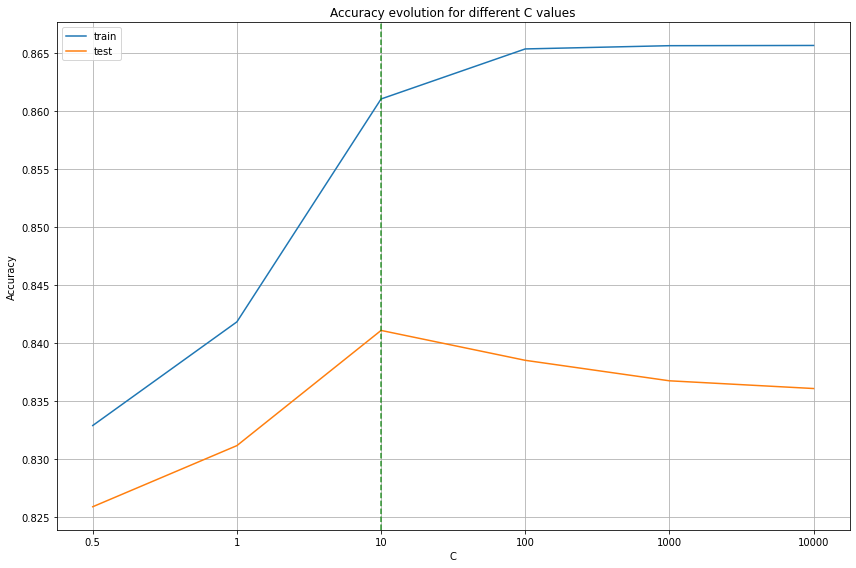

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Me quedo con C = 10, ya que el accurary en train sigue aumentando para valores de C más altos, pero en test no. Por tanto, si aumentamos C podríamos estar en overfitting.

In [ ]:
#C=10
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=2000,verbose=2)
lr.fit(features_normalitation_train, labels_train)
    
train_predict = lr.predict(features_normalitation_train)
test_predict = lr.predict(features_normalitation_test)
print('Confussion matrix:\n{}'.format(confusion_matrix(labels_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(labels_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(labels_test, test_predict)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min finished


Confussion matrix:
[[18289  2442]
 [ 3049 10772]]

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     20731
           1       0.82      0.78      0.80     13821

    accuracy                           0.84     34552
   macro avg       0.84      0.83      0.83     34552
weighted avg       0.84      0.84      0.84     34552

Accuracy score:0.8410801111368372


Parece que el modelo funciona más o menos bien, y en test obtiene un accuracy del 84%. 

A continuación creo dos funciones para ver distintas métricas de calidad del modelo, y dibujar la matriz de confusión.

In [16]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [17]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

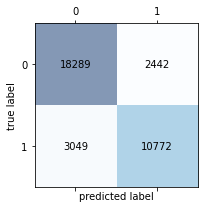

ACC:  0.8410801111368372
SEN:  0.779393676289704
ESP:  0.8822053928898751
PPV:  0.8151960042379295
FSC:  0.7968929165896061


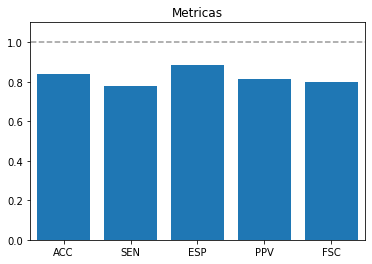

In [ ]:
plot_confusion_matrix(confusion_matrix(labels_test, test_predict))
calcula_metricas(confusion_matrix(labels_test, test_predict))

In [ ]:
# Guardamos el modelo:

filename = 'logistic_beauty_health.plk'
pickle.dump(lr, open(cache_dir+filename, 'wb'))


## Gradient Boosting

El siguiente modelo es un gradient boosting. 

In [ ]:
def classify_gboost(X_train, X_test, y_train, y_test,n_estimators,learning_rate,max_depth):        
    clf = GradientBoostingClassifier( learning_rate = learning_rate,n_estimators= n_estimators,max_depth=max_depth, random_state=42,verbose = 2)

    clf.fit(X_train, y_train)
    print("Max_Depth: {}, learning_rate: {},n_estimator: {}".format(max_depth,learning_rate,n_estimators) )
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    return clf




Probé varios modelos, con más profundidad, otras learning rate, ampliando n_estimators, pero el bucle era tan pesado que se reiniciaba el colab. Al final he dejado el modelo que parecía que iba a converger mejor.

In [ ]:
n_estimators = [100]
learning_rate = [0.01]
maxDepth = [6]
for m in maxDepth:
  for n in n_estimators:
    for l in learning_rate:
          
          clf2 = classify_gboost(features_normalitation_train, features_normalitation_test, labels_train, labels_test,n,l,m)

      Iter       Train Loss   Remaining Time 
         1           1.3423          194.61m
         2           1.3387          208.72m
         3           1.3352          199.89m
         4           1.3317          193.52m
         5           1.3282          190.97m
         6           1.3249          187.48m
         7           1.3215          184.60m
         8           1.3183          182.56m
         9           1.3151          181.20m
        10           1.3120          182.09m
        11           1.3088          180.66m
        12           1.3058          180.09m
        13           1.3028          178.73m
        14           1.2999          176.08m
        15           1.2970          173.24m
        16           1.2941          170.70m
        17           1.2913          168.00m
        18           1.2885          165.43m
        19           1.2858          163.91m
        20           1.2831          162.09m
        21           1.2805          159.93m
        2

In [ ]:
gboost = clf2

In [ ]:
train_predict = gboost.predict(features_normalitation_train)
test_predict = gboost.predict(features_normalitation_test)
print('Confussion matrix:\n{}'.format(confusion_matrix(labels_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(labels_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(labels_test, test_predict)))

Confussion matrix:
[[19053  1678]
 [ 8410  5411]]

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79     20731
           1       0.76      0.39      0.52     13821

    accuracy                           0.71     34552
   macro avg       0.73      0.66      0.65     34552
weighted avg       0.72      0.71      0.68     34552

Accuracy score:0.7080342671914795


Los resultados son bastante peores que con la regresión logística, puede que no hayamos dado con los parámetros que optimizan el modelo. Para eso ,necesitaríamos mediante gridsearch buscar el modelo óptimo, y ver si podemos mejorar la regresión logística.

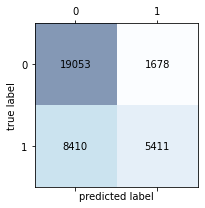

ACC:  0.7080342671914795
SEN:  0.39150567976267997
ESP:  0.9190584149341566
PPV:  0.7632952461560164
FSC:  0.5175514108082256


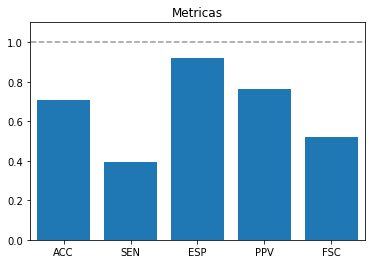

In [ ]:
plot_confusion_matrix(confusion_matrix(labels_test, test_predict))
calcula_metricas(confusion_matrix(labels_test, test_predict))

Vemos que funciona especialmente mal para estimar reviews negativas.

## Redes neuronales

In [ ]:
max = 0
mean = []
for s in words_train:
  length = len(s)
  mean.append(len(s))
  if length > max:
    max = length

In [ ]:
#Tiene sentido, cuando extraje las features, ya le puse máximo de 5000
print(sum(mean) / len(mean))
print(max)

96.11823102080982
5416


## LSTM

Voy a empezar con una LSTM. He probado varios modelos con distintos número de capas, y tenía la sensación de estar en overfitting ya que la función de pérdidas en train seguía mejorando en cada época pero en validación se estancaba e incluso empeoraba. Al final, he decido meter una capa dropout para tratar de controlar eso. Uso 5 épocas que parece que con eso el modelo ya obtiene buenos resultados, y no sobreajusta tanto.

In [ ]:
vocabulary_size

64496

In [ ]:
max_words = 10000
embedding_size = 32
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_lstm.add(LSTM(80))
model_lstm.add( Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 32)         2063872   
                                                                 
 lstm_1 (LSTM)               (None, 80)                36160     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 2,100,113
Trainable params: 2,100,113
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Para el modelo con redes neuronales, como inputs,usamos los datos tokenizados. Incluyendo padding.

In [ ]:
batch_size = 32
num_epochs = 5
words_train_pdg = sequence.pad_sequences(words_tokenizer_train, maxlen=10000)
model_lstm.fit(words_train_pdg[:90000], labels_train[:90000],validation_data=(words_train_pdg[90000:], labels_train[90000:]),
          batch_size=batch_size, epochs=num_epochs,verbose = 2)

Epoch 1/5
2813/2813 - 817s - loss: 0.4204 - accuracy: 0.8088 - val_loss: 0.3627 - val_accuracy: 0.8450 - 817s/epoch - 290ms/step
Epoch 2/5
2813/2813 - 829s - loss: 0.3254 - accuracy: 0.8632 - val_loss: 0.3224 - val_accuracy: 0.8600 - 829s/epoch - 295ms/step
Epoch 3/5
2813/2813 - 851s - loss: 0.2709 - accuracy: 0.8909 - val_loss: 0.3154 - val_accuracy: 0.8693 - 851s/epoch - 303ms/step
Epoch 4/5
2813/2813 - 814s - loss: 0.2386 - accuracy: 0.9057 - val_loss: 0.3199 - val_accuracy: 0.8668 - 814s/epoch - 289ms/step
Epoch 5/5
2813/2813 - 814s - loss: 0.2137 - accuracy: 0.9161 - val_loss: 0.3299 - val_accuracy: 0.8651 - 814s/epoch - 290ms/step


In [ ]:
filename = "lstm.h5"  # HDF5 file
model_lstm.save(os.path.join(cache_dir, filename))

In [ ]:
words_test_pdg = sequence.pad_sequences(words_tokenizer_test, maxlen=10000)
scores = model_lstm.evaluate(words_test_pdg, labels_test, verbose=2) 
print("Test accuracy:", scores[1])  

1080/1080 - 118s - loss: 0.3337 - accuracy: 0.8657 - 118s/epoch - 109ms/step
Test accuracy: 0.865709662437439


Con este modelo, si conseguimos mejorar la regresión logística.

In [ ]:
train_predict = model_lstm.predict(words_train_pdg )
test_predict = model_lstm.predict(words_test_pdg )

In [ ]:

prediction_labels_train=np.array(list(map(lambda x: 1 if x >0.5 else 0,train_predict)))
prediction_labels_test=np.array(list(map(lambda x: 1 if x >0.5 else 0,test_predict)))

print('Confussion matrix:\n{}'.format(confusion_matrix(labels_test, prediction_labels_test)))
print('\nClassification report:\n{}'.format(classification_report(labels_test, prediction_labels_test)))
print('Accuracy score:{}'.format(accuracy_score(labels_test, prediction_labels_test)))

Confussion matrix:
[[18857  1874]
 [ 2766 11055]]

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     20731
           1       0.86      0.80      0.83     13821

    accuracy                           0.87     34552
   macro avg       0.86      0.85      0.86     34552
weighted avg       0.87      0.87      0.86     34552

Accuracy score:0.8657096550127344


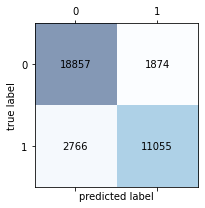

ACC:  0.8657096550127344
SEN:  0.7998697634035163
ESP:  0.9096039747238435
PPV:  0.8550545285791631
FSC:  0.8265420560747664


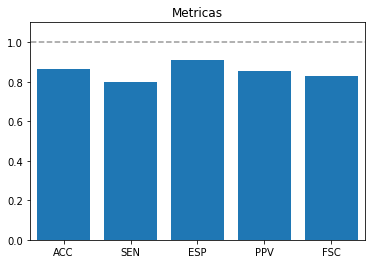

In [ ]:
plot_confusion_matrix(confusion_matrix(labels_test, prediction_labels_test))
calcula_metricas(confusion_matrix(labels_test, prediction_labels_test))

Parece que se equivoca algo más al estimar las reviews negativas, pero está más o menos equiparado.

## GRU

In [8]:
embedding_size = 32
max_words = 10000
model_gru = Sequential()
model_gru.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_gru.add(GRU(90))
model_gru.add( Dropout(0.2))
model_gru.add(Dense(1, activation='sigmoid'))

In [9]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
batch_size = 32
num_epochs = 5

#words_train_pdg = sequence.pad_sequences(words_tokenizer_train, maxlen=10000)
model_gru.fit(words_train_pdg[:90000], labels_train[:90000],validation_data=(words_train_pdg[90000:], labels_train[90000:]),
          batch_size=batch_size, epochs=num_epochs,verbose = 2)

Epoch 1/5
2813/2813 - 1498s - loss: 0.3905 - accuracy: 0.8214 - val_loss: 0.3260 - val_accuracy: 0.8577 - 1498s/epoch - 533ms/step
Epoch 2/5
2813/2813 - 1490s - loss: 0.2859 - accuracy: 0.8790 - val_loss: 0.3036 - val_accuracy: 0.8701 - 1490s/epoch - 530ms/step
Epoch 3/5
2813/2813 - 1493s - loss: 0.2436 - accuracy: 0.9008 - val_loss: 0.3110 - val_accuracy: 0.8694 - 1493s/epoch - 531ms/step
Epoch 4/5
2813/2813 - 1494s - loss: 0.2089 - accuracy: 0.9169 - val_loss: 0.3194 - val_accuracy: 0.8723 - 1494s/epoch - 531ms/step
Epoch 5/5
2813/2813 - 1493s - loss: 0.1783 - accuracy: 0.9308 - val_loss: 0.3320 - val_accuracy: 0.8668 - 1493s/epoch - 531ms/step


In [11]:
#model_gru.save(cache_dir+'gru.h5')
model_file = "gru.h5"  # HDF5 file
model_gru.save(os.path.join(cache_dir, model_file))

In [13]:
#words_test_pdg = sequence.pad_sequences(words_tokenizer_test, maxlen=10000)
scores = model_gru.evaluate(words_test_pdg , labels_test, verbose=2)  
print("Test accuracy:", scores[1])

1080/1080 - 154s - loss: 0.3282 - accuracy: 0.8702 - 154s/epoch - 143ms/step
Test accuracy: 0.8701667189598083


Parece que la GRU obtiene algo mejores resultados que la LSTM.

In [14]:
train_predict = model_gru.predict(words_train_pdg)
test_predict = model_gru.predict(words_test_pdg)
prediction_labels_train=np.array(list(map(lambda x: 1 if x >0.5 else 0,train_predict)))
prediction_labels_test=np.array(list(map(lambda x: 1 if x >0.5 else 0,test_predict)))

print('Confussion matrix:\n{}'.format(confusion_matrix(labels_test, prediction_labels_test)))
print('\nClassification report:\n{}'.format(classification_report(labels_test, prediction_labels_test)))
print('Accuracy score:{}'.format(accuracy_score(labels_test, prediction_labels_test)))

Confussion matrix:
[[18521  2210]
 [ 2276 11545]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     20731
           1       0.84      0.84      0.84     13821

    accuracy                           0.87     34552
   macro avg       0.86      0.86      0.86     34552
weighted avg       0.87      0.87      0.87     34552

Accuracy score:0.8701667052558463


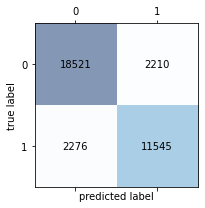

ACC:  0.8701667052558463
SEN:  0.835323059112944
ESP:  0.8933963629347355
PPV:  0.8393311523082515
FSC:  0.8373223092544242


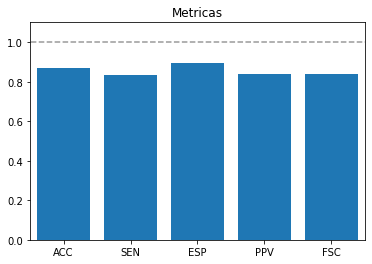

In [18]:
plot_confusion_matrix(confusion_matrix(labels_test, prediction_labels_test))
calcula_metricas(confusion_matrix(labels_test, prediction_labels_test))

Parece además que estima con la misma precisión,más o menos, las reviews negativas y positivas.

Como modelo final, nos quedamos con la GRU.